In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D,MullerBrownPotential



In [3]:
gamma = 1/0.05
kT = 2.49432

In [4]:
import mdtraj as mdt
import numpy as np
xtc_file = r"/home/tdevergne@iit.local/Documents/ala_metad/phi/alanine_no_jump.xtc"
pdb_file = r"/home/tdevergne@iit.local/Documents/ala_metad/phi/input.ala2.pdb"

colvars = np.loadtxt("/home/tdevergne@iit.local/Documents/ala_metad/phi/COLVAR")
bias = colvars[:,-5]
n_samples = colvars.shape[0] 

derivatives = np.loadtxt("/home/tdevergne@iit.local/Documents/ala_metad/phi/deriv_cv")[:,-1].reshape(n_samples,9,3) #derivatives have 9 entries
force_bias = np.loadtxt("/home/tdevergne@iit.local/Documents/ala_metad/phi/forces_opes")[:,-1]



#output_file = r"your\path\output_file.txt"

#Read in xtc file
trajectory = mdt.load(xtc_file, top=pdb_file) 
trajectory_xyz = trajectory.xyz
n_atoms = trajectory_xyz.shape[1]
forces = np.loadtxt("/home/tdevergne@iit.local/Documents/ala_metad/phi/force.xvg",comments=["#","@"])
print(forces.shape)
forces = forces[:,1:].reshape(n_samples,n_atoms,3)
velocities = np.loadtxt("/home/tdevergne@iit.local/Documents/ala_metad/phi/veloc.xvg",comments=["#","@"])
velocities = velocities[:,1:].reshape(n_samples,n_atoms,3)

cv_derivatives = np.zeros((derivatives.shape[0],4,3))

#SEE PLUMED SOURCE CODE FOR TORSION ANGLE
cv_derivatives[:,0] = derivatives[:,0]
cv_derivatives[:,1] = derivatives[:,1] + derivatives[:,2]
cv_derivatives[:,2] = derivatives[:,3] + derivatives[:,4]
cv_derivatives[:,3] = derivatives[:,5]

mask = [4,6,8,14]
unbiased_forces = np.zeros(forces.shape)
unbiased_forces = forces
unbiased_forces[:,mask,:] -= force_bias[:,np.newaxis,np.newaxis] * cv_derivatives

masses = np.array([atom.element.mass for atom in trajectory.top.atoms])


(2501, 67)


In [5]:
heavy = np.where(masses>2.0)[0]
velocities = velocities[:,heavy,:]
trajectory_xyz = trajectory_xyz[:,heavy,:]
unbiased_forces = unbiased_forces[:,heavy,:]
n_atoms = heavy.shape[0]

In [6]:
print(colvars[:,5:50].shape)
print(trajectory_xyz.shape)
print(velocities.shape)

(2501, 45)
(2501, 10, 3)
(2501, 10, 3)


In [7]:
total_sample = np.concatenate((velocities,trajectory_xyz),axis=-1).reshape(n_samples,6*n_atoms)
total_forces = np.hstack((unbiased_forces/masses[np.newaxis,heavy,np.newaxis] - velocities*gamma,velocities)).reshape(n_samples,n_atoms*6)
#total_forces = unbiased_forces/(masses[np.newaxis,heavy,np.newaxis]*gamma)

In [8]:
total_sample.reshape(n_samples,n_atoms,6)[0]

array([[-0.0226322 , -0.453381  ,  0.242137  ,  0.17500001,  0.76300001,
         0.65700001],
       [ 0.278064  ,  1.10951   , -0.412695  ,  0.289     ,  0.70100003,
         0.72600001],
       [-0.296661  ,  0.111062  , -0.114446  ,  0.38300002,  0.77300006,
         0.74200004],
       [-0.135464  ,  0.679122  , -0.285391  ,  0.29200003,  0.57300001,
         0.76000005],
       [ 0.121467  , -0.227872  , -0.542795  ,  0.41600001,  0.50100005,
         0.81400001],
       [ 0.0808274 , -0.734731  ,  0.308555  ,  0.354     ,  0.38200003,
         0.89000005],
       [-0.713007  , -0.0415518 , -0.0174564 ,  0.53200001,  0.47200003,
         0.71300006],
       [ 0.427048  ,  0.469422  , -0.352435  ,  0.56      ,  0.35700002,
         0.68600005],
       [ 0.00829425, -0.687421  ,  0.657015  ,  0.588     ,  0.57800001,
         0.65100002],
       [-0.568876  , -0.270387  ,  0.30726   ,  0.69100004,  0.57800001,
         0.54900002]])

In [9]:
trajectory_xyz[0]

array([[0.17500001, 0.763     , 0.657     ],
       [0.289     , 0.70100003, 0.726     ],
       [0.38300002, 0.77300006, 0.74200004],
       [0.29200003, 0.573     , 0.76000005],
       [0.416     , 0.50100005, 0.814     ],
       [0.354     , 0.38200003, 0.89000005],
       [0.532     , 0.47200003, 0.71300006],
       [0.56      , 0.35700002, 0.68600005],
       [0.588     , 0.578     , 0.651     ],
       [0.69100004, 0.578     , 0.549     ]], dtype=float32)

In [10]:
mean = np.mean(total_sample,axis=0)
norm = np.linalg.norm(total_sample,axis=0)

#total_sample -= mean
#total_sample /= norm

friction = np.ones(30)
friction*= 2 * kT / gamma
friction

array([0.249432, 0.249432, 0.249432, 0.249432, 0.249432, 0.249432,
       0.249432, 0.249432, 0.249432, 0.249432, 0.249432, 0.249432,
       0.249432, 0.249432, 0.249432, 0.249432, 0.249432, 0.249432,
       0.249432, 0.249432, 0.249432, 0.249432, 0.249432, 0.249432,
       0.249432, 0.249432, 0.249432, 0.249432, 0.249432, 0.249432])

In [11]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn.models import kernel_generator
#0.2 1e-2 1000 PCR
from sklearn.preprocessing import StandardScaler

length_scale = np.array([0.5]*45)#np.array([2.0]*n_atoms*3 + [0.5]*n_atoms*3)
#print(length_scale.shape)
kernel = RBF(length_scale=0.5) #0.345 works  well #0.4 best
print(kernel.length_scale)
model = kooplearn.models.kernel_generator.KernelInverseGenerator(kernel, reduced_rank=False, eta=1e-5, rank=5
                                
                            
                                   , tikhonov_reg=5e-5, transform=True
)
kernel1 = RBF(length_scale=0.9)
model1 = kooplearn.models.KernelDMD(kernel1,reduced_rank=False,rank=6,tikhonov_reg=1e-3)

0.5


In [12]:
def force(x):
    return -40*x*(x**2-1)
train_data = traj_to_contexts(total_sample[::200])
forces_train = traj_to_contexts(total_forces[::200])
train_distances = traj_to_contexts(colvars[::200,5:50])
positions_context = traj_to_contexts(trajectory_xyz[::200].reshape(-1,3*n_atoms))
print(train_data.shape)
weights =np.exp(bias/2)
weights_context = traj_to_contexts(weights[::200])


(12, 2, 60)


In [13]:


#model_correction = model.fit(train_data,forces=(forces_train),friction=friction, weights=weights_context) #np.sqrt(2))


In [14]:
vals_gen_correction, vecs_gen_correction = model_correction.eig(eval_right_on=train_data[:,:1, ...])

NameError: name 'model_correction' is not defined

In [ ]:

print(1e-3 - 1/vals_gen_correction)


[25.04736216+0.j         -0.13782459-1.49413861j -0.13782459+1.49413861j
 -2.38966487+0.j         -2.10333629+0.j        ]


###### 

(0.024537094885257037+0j)
(-0.017552256918124936+0j)


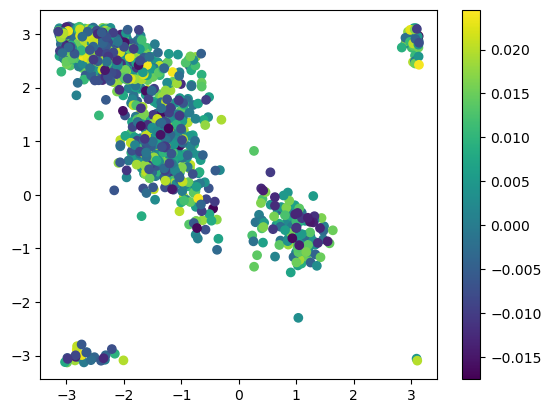

In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

print(vecs_gen_correction[:,-2].max())
print(vecs_gen_correction[:,-2].min())

#plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs[:,-4]/vecs[:,-1],label="PCR generator first eigenfunction")
plt.scatter(colvars[1::20,1],colvars[1::20,2],c=vecs_gen_correction[:,-2])#/vecs_gen_correction[:,-1],cmap='RdGy')
plt.colorbar()


In [ ]:
vecs_gen_correction[:,-2]

array([-0.00293258+0.j, -0.00395185+0.j, -0.00302902+0.j, ...,
       -0.00541311+0.j, -0.01077512+0.j, -0.00848942+0.j])

In [ ]:
colvars[::200][-1,5:50]

array([0.14544 , 0.231374, 0.237635, 0.379108, 0.463126, 0.478931,
       0.577695, 0.488113, 0.627821, 0.12012 , 0.133519, 0.249681,
       0.360411, 0.346349, 0.45366 , 0.354826, 0.498353, 0.22225 ,
       0.2818  , 0.413443, 0.353772, 0.472833, 0.326215, 0.457114,
       0.149929, 0.242492, 0.263203, 0.3522  , 0.318677, 0.466242,
       0.155531, 0.156137, 0.241493, 0.247029, 0.385175, 0.263962,
       0.288517, 0.383542, 0.505714, 0.121128, 0.133365, 0.246748,
       0.223131, 0.280442, 0.148561])

In [ ]:
import jax.hvp

In [141]:
from jax import jacrev, vmap,jacfwd,jit,grad, jvp, hessian
import jax.numpy as jnp
import jax.lax
import tqdm
import functools
def transform_to_distances(X):
    X = X.reshape(X.shape[0], -1)
    n_samples = X.shape[0]
    positions_velocities = X.reshape(n_samples, -1, 6)
    velocities = positions_velocities[:, :, :3]
    positions = positions_velocities[:, :, 3:]
    distances = compute_distances(positions)
    jacobian = vmap(jacfwd(compute_distances_one))(positions)
    new_velocities = jnp.einsum("ijkl,ikl->ij", jacobian, velocities)
    return jnp.concatenate((new_velocities, distances),axis=-1).reshape(n_samples, -1)

def compute_kernel_one(Y,X):
    n_atoms = X.shape[0] // 6
    length_scale = 10
    #reshaped_X = X.reshape(-1, 6)
    #velocities_X = reshaped_X[:, :3]
    #positions_X = reshaped_X[:, 3:]
    #distances = compute_distances_one(positions_X)  
    #jacobian = jacfwd(compute_distances_one)(positions_X)
    #new_velocities = jnp.einsum("jkl,kl->j", jacobian, velocities_X)
    #features = jnp.concatenate((new_velocities, distances)) 
    #return jnp.exp(-jnp.linalg.norm((features[jnp.newaxis, :] - Y)/length_scale, axis=-1) ** 2)[0]
    return jnp.exp(-jnp.linalg.norm((X - Y)/length_scale, axis=-1) ** 2)[0]
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

def compute_kernel_hessian(X, chunks, forces):
    n_samples = X.shape[0]
    

    batched_dataset = jnp.array_split(X,chunks)
    for i_batch in tqdm.tqdm(range(chunks)):
        for j_batch in range(chunks):
            #features_Y = X#transform_to_distances(batched_dataset[j_batch])
            kernel_jacobian =  jit(vmap(jacfwd(compute_kernel_one,argnums=1),in_axes=(0,None)))(batched_dataset[j_batch],batched_dataset[i_batch])
            #reduced_func = functools.partial(compute_kernel_one,features_Y[1])
            #try_ =hvp(reduced_func,(batched_dataset[i_batch][0],),(jnp.ones_like(batched_dataset[i_batch][0]),))
            #print(try_)
            #kernel_hessian =  jit(vmap(hessian(compute_kernel_one,argnums=0),in_axes=(0,None)))(batched_dataset[i_batch],features_Y)
            print(kernel_jacobian.shape)
    return 0

def compute_distances(positions):
    distance_tensor = jnp.zeros((positions.shape[0], 45))
    idx = 0
    for i in range(positions.shape[1]):
        for j in range(i + 1, positions.shape[1]):
            distance_ij = jnp.sqrt(jnp.sum((positions[:, i, :] - positions[:, j, :]) ** 2, axis=-1))
            distance_tensor = distance_tensor.at[:, idx].set(distance_ij)
            idx += 1
    return distance_tensor

def compute_distances_one_two(positions):
    # Compute pairwise differences
    pairwise_diff = positions[:, None, :] - positions[None, :, :]
    
    # Compute squared distances along the last axis, then take the square root
    distances = jnp.sqrt(jnp.sum(pairwise_diff ** 2, axis=-1))
    
    # Filter out distances to the same point and flatten the upper triangle
    distances = distances[jnp.triu_indices(positions.shape[0], k=1)]
    
    return distances
  
def compute_distances_one(positions,velocities):   
    distance_tensor = jnp.zeros((45))
    velocities_tensor = jnp.zeros((45))
    idx = 0
    for i in range(positions.shape[0]):
        for j in range(i + 1, positions.shape[0]):
            distance_ij = jnp.sqrt(jnp.sum((positions[i, :] - positions[j, :]) ** 2, axis=-1))
            distance_tensor.at[idx].set(distance_ij)
            idx += 1
    return distance_tensor

In [142]:
jacobian = compute_kernel_hessian(total_sample,50, total_forces)

  0%|          | 0/50 [00:00<?, ?it/s]

(51, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)
(50, 51, 60)


  0%|          | 0/50 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
compute_distances_one_two(trajectory_xyz[0]).shape

(45,)

In [ ]:
features_Y = transform_to_distances(total_sample[::2])

In [ ]:
print(jacobian[2,0])
kernel = compute_kernel_one(X[0],features_Y)
#-2*(X[1]-X)*np.exp(-np.linalg.norm((X[1]-X)/10,axis=-1)**2)[:,np.newaxis]/100

[ 0.00958289 -0.00307924  0.0051221  -0.02706587  0.00144909  0.00439252
 -0.01087853  0.08940794  0.00956078 -0.2601257  -0.04760308 -0.29559636
 -0.00309668 -0.03126461 -0.04296957  0.08316503 -0.04469563 -0.0655627
  0.03644014  0.01438745  0.00097794 -0.0505715   0.00196834  0.1397748
  0.05131167  0.01668895 -0.02918539 -0.03460037  0.02059763 -0.03636589
 -0.01192123 -0.08506441  0.04616208  0.18108559  0.11179676  0.08851245
  0.01060723  0.01892028 -0.00226735  0.04815063  0.03001056 -0.01043438
  0.02858331  0.03908354  0.00663742  0.0124254   0.02140625 -0.03915311
 -0.01507911 -0.03093085 -0.00898945 -0.02252945  0.0380071  -0.03302347
 -0.09554968 -0.02814904  0.01495143  0.07006628 -0.13293703  0.2474561 ]


NameError: name 'X' is not defined

In [ ]:
kernel[1]

TypeError: 'RBF' object is not subscriptable

In [ ]:
compute_distances_one(trajectory_xyz[0])-colvars[0,5:50]

Array([ 1.77323818e-06,  1.20103359e-05, -6.92903996e-06, -1.90734863e-06,
       -1.28746033e-05,  9.65595245e-06,  9.59634781e-06,  1.44541264e-05,
        1.84178352e-05,  2.45869160e-07, -7.33137131e-06,  5.96046448e-08,
       -1.11460686e-05,  1.49011612e-07, -4.76837158e-07, -4.94718552e-06,
        3.15904617e-06, -1.35451555e-05,  1.66893005e-06, -2.34246254e-05,
       -2.08616257e-07, -2.68220901e-07, -6.67572021e-06,  1.69277191e-05,
       -8.25524330e-06, -4.55975533e-06, -7.98702240e-06, -4.17232513e-06,
       -1.39474869e-05, -9.53674316e-06, -3.60757113e-05, -1.65402889e-06,
       -2.27987766e-06, -1.43051147e-06,  1.32322311e-05, -3.77893448e-05,
       -2.98619270e-05, -3.76105309e-05, -2.79545784e-05,  1.78813934e-07,
        2.65240669e-06,  8.40425491e-06,  5.43892384e-06, -4.38094139e-06,
        2.26497650e-05], dtype=float32)

In [ ]:
X =  total_sample[::2]
compute_kernel_one(X[0],X)

ValueError: Incompatible shapes for broadcasting: shapes=[(90,), (1251, 60)]

In [ ]:
ux(x).shape

(20, 1)

In [ ]:

def gram(kernel, xs):
  '''Compute a Gram matrix from a kernel and an array of data points.

  Args:
    kernel: callable, maps pairs of data points to scalars.
    xs: array of data points, stacked along the leading dimension.

  Returns:
    A 2d array `a` such that `a[i, j] = kernel(xs[i], xs[j])`.
  '''
  return vmap(lambda x: vmap(lambda y: kernel(x, y))(xs))(xs)
def kernel(x,y):
  return jnp.exp(-jnp.linalg.norm((x-y)/10)**2)
X = total_sample
grad(gram,argnums=0)(kernel,X)

TypeError: Argument '<function kernel at 0x7fc5ec6a16c0>' of type <class 'function'> is not a valid JAX type.

In [ ]:
gram_matrix.shape

(2501, 2501)

In [ ]:
import jax

In [ ]:
jax.copy()

AttributeError: module 'jax' has no attribute 'copy'

In [ ]:
compute_kernel_hessian(torch.tensor(total_sample[::200],requires_grad=True))

TypeError: vmap() got an unexpected keyword argument 'in_axes'

In [206]:
import functools
import jax
from jax import vmap, jacobian,jacfwd
import jax.numpy as jnp
def compute_distances_one(positions,velocities):   
    distance_tensor = jnp.zeros((45))
    velocities_tensor = jnp.zeros((45))
    idx = 0
    for i in range(positions.shape[0]):
        for j in range(i + 1, positions.shape[0]):
            distance_ij = jnp.sqrt(jnp.sum((positions[i, :] - positions[j, :]) ** 2, axis=-1))
            distance_tensor = distance_tensor.at[idx].set(distance_ij)
            velocities_tensor = velocities_tensor.at[idx].set(jnp.dot((positions[i, :] - positions[j, :]),velocities.at[i,:].get()-velocities.at[j,:].get())/distance_ij)
            idx += 1
    return distance_tensor, velocities_tensor
def compute_distances_one(positions, velocities):
    num_particles = positions.shape[0]
    idx = jnp.triu_indices(num_particles, k=1)
    pos_diff = positions[idx[0]] - positions[idx[1]]
    distance_tensor = jnp.linalg.norm(pos_diff, axis=1)
    vel_diff = velocities[idx[0]] - velocities[idx[1]]
    velocities_tensor = jnp.sum(pos_diff * vel_diff, axis=1) / distance_tensor
    return distance_tensor, velocities_tensor
def compute_distances_one_no_v(positions):   
    distance_tensor = jnp.zeros((45))
    idx = 0
    for i in range(positions.shape[0]):
        for j in range(i + 1, positions.shape[0]):
            distance_ij = jnp.sqrt(jnp.sum((positions[i, :] - positions[j, :]) ** 2, axis=-1))
            distance_tensor.at[idx].set(distance_ij)
            idx += 1
    return distance_tensor
def compute_distances(positions):
    distance_tensor = jnp.zeros((positions.shape[0], 45))
    idx = 0
    for i in range(positions.shape[1]):
        for j in range(i + 1, positions.shape[1]):
            distance_ij = jnp.sqrt(jnp.sum((positions[:, i, :] - positions[:, j, :]) ** 2, axis=-1))
            distance_tensor = distance_tensor.at[:, idx].set(distance_ij)
            idx += 1
    return distance_tensor

def transform_to_distances(X):
    X = X.reshape(X.shape[0], -1)
    n_samples = X.shape[0]
    positions_velocities = X.reshape(n_samples, -1, 6)
    velocities = positions_velocities[:, :, :3]
    positions = positions_velocities[:, :, 3:]
    distances = compute_distances(positions)
    jacobian = vmap(jacfwd(compute_distances_one_no_v))(positions)
    new_velocities = jnp.einsum("ijkl,ikl->ij", jacobian, velocities)
    return jnp.concatenate((new_velocities, distances),axis=-1).reshape(n_samples, -1)

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return np.random.random((N,60)), Y, X_test
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)
X, Y, X_test = get_2d_data(1000, sigma_obs=0.1)

test_X = X
test_Y = X
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

@jax.jit
def rbf_kernel(params, x, y):
    #x_resh = x.reshape(-1,6)
    distances,velocities = compute_distances_one(y.at[:,3:].get(),y.at[:,:3].get())

    features = jnp.concatenate((velocities, distances)) 
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(features,x))

params = {'gamma': 1.0, 'var_f': 1.0}

def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(x))(y)

def compute_kernel_hessian(X, chunks, length_scale):
    n_samples = X.shape[0]
    

    batched_dataset = jnp.array_split(X,chunks)
    features_Y = transform_to_distances(X)
    batched_features = jnp.array_split(features_Y,chunks)
    for i_batch in tqdm.tqdm(range(chunks)):
        for j_batch in range(chunks):
# define the cross operator K_fg(x, y), dK wrt x
            drbf_kernel_fg = jax.hessian(rbf_kernel, argnums=(1))

            K_func = functools.partial(drbf_kernel_fg, params)

# calculate kernel matrix
            dK_fg = gram(K_func, batched_dataset[i_batch].reshape(len(batched_dataset[i_batch]),-1,6), batched_features[j_batch])
            #print(dK_fg)





In [212]:
compute_kernel_hessian(total_sample,128,None)

 76%|███████▌  | 97/128 [05:47<01:31,  2.95s/it]

In [ ]:
features_Y = transform_to_distances(total_sample)

In [ ]:

dK_fg = gram(K_func, features_Y[::200],total_sample[::200])

In [ ]:
dK_fg.shape

(13, 13, 60, 60)

In [ ]:
dK_fg

Array([[[-4.4317175e-10,  3.2760350e-10, -1.5016392e-10, ...,
         -3.6169570e-10, -2.4769400e-10,  1.9285312e-10],
        [-4.4137838e-10,  3.2627775e-10, -1.4955624e-10, ...,
         -3.6629674e-10, -2.4656241e-10,  1.9449284e-10],
        [-4.3614709e-10,  3.2241065e-10, -1.4778369e-10, ...,
         -3.4902523e-10, -2.5272462e-10,  1.8891244e-10],
        ...,
        [-3.9911735e-10,  2.9503736e-10, -1.3523656e-10, ...,
         -2.8384683e-10, -2.4475649e-10,  1.5837237e-10],
        [-3.6716197e-10,  2.7141517e-10, -1.2440884e-10, ...,
         -2.5856928e-10, -2.3132968e-10,  1.4493411e-10],
        [-3.6773320e-10,  2.7183747e-10, -1.2460240e-10, ...,
         -2.5019611e-10, -2.3092739e-10,  1.4071734e-10]],

       [[ 2.4150101e-10, -3.0968295e-10,  4.7443338e-10, ...,
          8.1827656e-09,  5.2063363e-09,  1.0406384e-08],
        [ 2.4248228e-10, -3.1094122e-10,  4.7636117e-10, ...,
          8.1417477e-09,  5.2404898e-09,  1.0482509e-08],
        [ 2.3619076e-10, 

In [ ]:
distances,velocities_trans = compute_distances_one(jnp.array(trajectory_xyz[0]),jnp.array(velocities[0]))

0.14697278
0.22492
0.24576007
0.3890681
0.48113513
0.46396765
0.5602696
0.45258147
0.5586994
0.11948225
0.13247266
0.25273106
0.36452985
0.33415416
0.43974653
0.33189607
0.45613816
0.22046545
0.28329667
0.41907758
0.3371098
0.45554474
0.29720533
0.41247794
0.15321875
0.23921745
0.26459402
0.35207382
0.31547105
0.45138347
0.15421093
0.15651834
0.24053273
0.24916257
0.38958824
0.2666702
0.29099312
0.3876764
0.51794404
0.12140018
0.13496666
0.2518194
0.22549944
0.29115462
0.14495865


In [ ]:
distances

Array([0.14697278, 0.22492   , 0.24576007, 0.3890681 , 0.48113513,
       0.46396765, 0.5602696 , 0.45258147, 0.5586994 , 0.11948225,
       0.13247266, 0.25273106, 0.36452985, 0.33415416, 0.43974653,
       0.33189607, 0.45613816, 0.22046545, 0.28329667, 0.41907758,
       0.3371098 , 0.45554474, 0.29720533, 0.41247794, 0.15321875,
       0.23921745, 0.26459402, 0.35207382, 0.31547105, 0.45138347,
       0.15421093, 0.15651834, 0.24053273, 0.24916257, 0.38958824,
       0.2666702 , 0.29099312, 0.3876764 , 0.51794404, 0.12140018,
       0.13496666, 0.2518194 , 0.22549944, 0.29115462, 0.14495865],      dtype=float32)

In [ ]:
velocities_trans

Array([-0.73349124, -0.36307618, -1.150359  , -0.37934175,  0.2934498 ,
       -0.82084024, -0.39047945,  0.11838923, -0.57767916, -1.0138782 ,
        0.43916547,  0.934352  ,  1.9032118 ,  0.05274455,  0.587053  ,
        0.18118073, -0.65369356, -0.5958211 ,  0.2652596 ,  0.91238976,
       -0.0560989 , -0.01680169,  0.49802968, -0.22025163,  0.5434268 ,
        1.5077033 , -0.2963604 ,  0.5709304 , -0.21238892, -0.6706677 ,
        0.8270394 , -0.99196965, -0.3358078 , -1.0050465 , -1.0739096 ,
       -0.07954536,  0.60503   , -0.2346853 , -0.24615994, -0.14658983,
       -0.51780576, -0.21679507, -1.3424343 , -1.3200618 , -0.1640023 ],      dtype=float32)

In [ ]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

# fix params for kernel function
K_func = functools.partial(dK_fg_func, params)

# calculate kernel matrix
d2K_fg2 = gram(K_func, features_Y, total_sample[::2])

# get the diagonal terms
d2K_fg2 = jnp.diagonal(d2K_fg2, axis1=2, axis2=3)

d2K_fg2.shape


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 1529538304300 bytes.

In [139]:
import torch
import functorch
import functools
def transform_to_distances(X):
    X = X.reshape(X.shape[0], -1)
    n_samples = X.shape[0]
    positions_velocities = X.reshape(n_samples, -1, 6)
    velocities = positions_velocities[:, :, :3]
    positions = positions_velocities[:, :, 3:]
    distances = compute_distances(positions)
    jacobian = functorch.vmap(functorch.jacfwd(compute_distances_one))(positions)
    new_velocities = torch.einsum("ijkl,ikl->ij", jacobian, velocities)
    return torch.concatenate((new_velocities, distances),axis=-1).reshape(n_samples, -1)

def compute_kernel_one(X,Y):
    length_scale = 8
    #reshaped_X = X.view(-1, 6)
    #velocities_X = reshaped_X[:, :3]
    #positions_X = reshaped_X[:, 3:]
    #distances, new_velocities = compute_distances_one_vel(positions_X,velocities_X)

    #jacobian = functorch.jacfwd(compute_distances_one)(positions_X)
    #new_velocities = torch.einsum("ikl,kl->i", jacobian, velocities_X).cuda()
    #features = torch.cat((new_velocities, distances), dim=0).view(-1)
    return torch.exp(-torch.sum((X- Y)/10, dim=-1) ** 2)
    #return torch.exp(-torch.sum((features.unsqueeze(0) - Y)/10, dim=-1) ** 2)
def compute_diagonal(X,Y):
    hessian = functorch.hessian(compute_kernel_one,argnums=0)(X,Y)
    return torch.diagonal(hessian,dim1=-1,dim2=-2)
def compute_kernel_hessian(X,chunks):
    n_samples = X.shape[0]
    batched_X = torch.split(X, chunks)
    n_batches = len(batched_X)
    
    for i_batch in tqdm.tqdm(range(n_batches)):
        for j_batch in range(n_batches):
            features_Y = batched_X[j_batch].clone().detach()
            #features_Y = transform_to_distances(batched_X[j_batch].clone().detach())
            #kernel = functorch.vmap(compute_kernel_one,in_dims=(0,None))(batched_X[i_batch],features_Y)
            jaco = functorch.vmap(functorch.jacfwd(compute_kernel_one,argnums=0),in_dims=(0,None))(batched_X[i_batch],features_Y)
            #new_func = functools.partial(compute_kernel_one,features_Y[1])
            #try_ = torch.autograd.functional.hvp(new_func,batched_X[i_batch][0],v=torch.ones_like(batched_X[i_batch][0]), create_graph=True, strict=True)
            #hess = functorch.jacfwd(functorch.jacrev(compute_kernel_one,argnums=0),argnums=0)( batched_X[i_batch][0],features_Y[1])
            print(jaco)

    return kernel_jacobian


def compute_distances(positions):
    distance_tensor = torch.zeros((positions.shape[0], 45))
    idx = 0
    for i in range(positions.shape[1]):
        for j in range(i + 1, positions.shape[1]):
            distance_ij = torch.sqrt(torch.sum((positions[:, i, :] - positions[:, j, :]) ** 2, dim=-1))
            distance_tensor[:, idx] = distance_ij
            idx += 1
    return distance_tensor


def compute_distances_one(positions):
    num_points = positions.shape[0]
    # Compute pairwise differences
    pairwise_diff = positions.unsqueeze(0) - positions.unsqueeze(1)
    # Compute pairwise squared distances
    pairwise_distances_squared = torch.sum(pairwise_diff ** 2, dim=-1)
    # Take square root to get distances
    distances = torch.sqrt(pairwise_distances_squared)
    # Mask out self-distances
    distances = distances[torch.triu(torch.ones(num_points, num_points), diagonal=1) == 1]
    return distances

def compute_distances_one_vel(positions, velocities):
    num_points = positions.shape[0]
    # Compute pairwise differences for positions
    pairwise_diff_positions = positions.unsqueeze(0) - positions.unsqueeze(1)
    # Compute pairwise squared distances
    pairwise_distances_squared = torch.sum(pairwise_diff_positions ** 2, dim=-1)
    # Take square root to get distances
    distances = torch.sqrt(pairwise_distances_squared)

    # Compute pairwise differences for velocities
    pairwise_diff_velocities = velocities.unsqueeze(0) - velocities.unsqueeze(1)
    # Compute pairwise dot products
    pairwise_dot_products = torch.sum(pairwise_diff_positions * pairwise_diff_velocities, dim=-1)/distances
    #print((pairwise_diff_positions/distances.unsqueeze(2)).size())
    # Mask out self-distances
    mask = torch.triu(torch.ones(num_points, num_points), diagonal=1) == 1
    distances = distances[mask]
    pairwise_dot_products = pairwise_dot_products[mask]

    return distances, pairwise_dot_products

In [140]:
jacobiuan, hessian = compute_kernel_hessian(torch.tensor(total_sample,requires_grad=True),10)

  0%|          | 0/251 [00:00<?, ?it/s]

tensor([[[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.0759,  0.0759,  0.0759,  ...,  0.0759,  0.0759,  0.0759],
         [ 0.0224,  0.0224,  0.0224,  ...,  0.0224,  0.0224,  0.0224],
         ...,
         [ 0.0124,  0.0124,  0.0124,  ...,  0.0124,  0.0124,  0.0124],
         [-0.0240, -0.0240, -0.0240,  ..., -0.0240, -0.0240, -0.0240],
         [ 0.0437,  0.0437,  0.0437,  ...,  0.0437,  0.0437,  0.0437]],

        [[-0.0759, -0.0759, -0.0759,  ..., -0.0759, -0.0759, -0.0759],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0635, -0.0635, -0.0635,  ..., -0.0635, -0.0635, -0.0635],
         ...,
         [-0.0697, -0.0697, -0.0697,  ..., -0.0697, -0.0697, -0.0697],
         [-0.0836, -0.0836, -0.0836,  ..., -0.0836, -0.0836, -0.0836],
         [-0.0461, -0.0461, -0.0461,  ..., -0.0461, -0.0461, -0.0461]],

        [[-0.0224, -0.0224, -0.0224,  ..., -0.0224, -0.0224, -0.0224],
         [ 0.0635,  0.0635,  0.0635,  ...,  0

  0%|          | 1/251 [00:00<03:47,  1.10it/s]

tensor([[[2.5181e-05, 2.5181e-05, 2.5181e-05,  ..., 2.5181e-05,
          2.5181e-05, 2.5181e-05],
         [4.3876e-04, 4.3876e-04, 4.3876e-04,  ..., 4.3876e-04,
          4.3876e-04, 4.3876e-04],
         [4.5176e-06, 4.5176e-06, 4.5176e-06,  ..., 4.5176e-06,
          4.5176e-06, 4.5176e-06],
         ...,
         [9.3946e-05, 9.3946e-05, 9.3946e-05,  ..., 9.3946e-05,
          9.3946e-05, 9.3946e-05],
         [5.5377e-05, 5.5377e-05, 5.5377e-05,  ..., 5.5377e-05,
          5.5377e-05, 5.5377e-05],
         [2.2200e-05, 2.2200e-05, 2.2200e-05,  ..., 2.2200e-05,
          2.2200e-05, 2.2200e-05]],

        [[3.5300e-04, 3.5300e-04, 3.5300e-04,  ..., 3.5300e-04,
          3.5300e-04, 3.5300e-04],
         [3.6260e-03, 3.6260e-03, 3.6260e-03,  ..., 3.6260e-03,
          3.6260e-03, 3.6260e-03],
         [8.3084e-05, 8.3084e-05, 8.3084e-05,  ..., 8.3084e-05,
          8.3084e-05, 8.3084e-05],
         ...,
         [1.0476e-03, 1.0476e-03, 1.0476e-03,  ..., 1.0476e-03,
          1.047

  1%|          | 2/251 [00:04<09:29,  2.29s/it]

tensor([[[3.6170e-09, 3.6170e-09, 3.6170e-09,  ..., 3.6170e-09,
          3.6170e-09, 3.6170e-09],
         [8.2454e-10, 8.2454e-10, 8.2454e-10,  ..., 8.2454e-10,
          8.2454e-10, 8.2454e-10],
         [2.2288e-08, 2.2288e-08, 2.2288e-08,  ..., 2.2288e-08,
          2.2288e-08, 2.2288e-08],
         ...,
         [2.6920e-08, 2.6920e-08, 2.6920e-08,  ..., 2.6920e-08,
          2.6920e-08, 2.6920e-08],
         [4.4446e-09, 4.4446e-09, 4.4446e-09,  ..., 4.4446e-09,
          4.4446e-09, 4.4446e-09],
         [7.7460e-10, 7.7460e-10, 7.7460e-10,  ..., 7.7460e-10,
          7.7460e-10, 7.7460e-10]],

        [[2.7080e-06, 2.7080e-06, 2.7080e-06,  ..., 2.7080e-06,
          2.7080e-06, 2.7080e-06],
         [8.3421e-07, 8.3421e-07, 8.3421e-07,  ..., 8.3421e-07,
          8.3421e-07, 8.3421e-07],
         [1.1308e-05, 1.1308e-05, 1.1308e-05,  ..., 1.1308e-05,
          1.1308e-05, 1.1308e-05],
         ...,
         [1.3099e-05, 1.3099e-05, 1.3099e-05,  ..., 1.3099e-05,
          1.309

  1%|          | 3/251 [00:07<11:19,  2.74s/it]

tensor([[[7.5902e-02, 7.5902e-02, 7.5902e-02,  ..., 7.5902e-02,
          7.5902e-02, 7.5902e-02],
         [1.4638e-09, 1.4638e-09, 1.4638e-09,  ..., 1.4638e-09,
          1.4638e-09, 1.4638e-09],
         [2.8148e-08, 2.8148e-08, 2.8148e-08,  ..., 2.8148e-08,
          2.8148e-08, 2.8148e-08],
         ...,
         [2.1972e-10, 2.1972e-10, 2.1972e-10,  ..., 2.1972e-10,
          2.1972e-10, 2.1972e-10],
         [8.4902e-03, 8.4902e-03, 8.4902e-03,  ..., 8.4902e-03,
          8.4902e-03, 8.4902e-03],
         [2.2573e-02, 2.2573e-02, 2.2573e-02,  ..., 2.2573e-02,
          2.2573e-02, 2.2573e-02]],

        [[8.1458e-02, 8.1458e-02, 8.1458e-02,  ..., 8.1458e-02,
          8.1458e-02, 8.1458e-02],
         [3.3035e-09, 3.3035e-09, 3.3035e-09,  ..., 3.3035e-09,
          3.3035e-09, 3.3035e-09],
         [5.9366e-08, 5.9366e-08, 5.9366e-08,  ..., 5.9366e-08,
          5.9366e-08, 5.9366e-08],
         ...,
         [5.1638e-10, 5.1638e-10, 5.1638e-10,  ..., 5.1638e-10,
          5.163

  2%|▏         | 4/251 [00:10<12:06,  2.94s/it]

tensor([[[6.8200e-06, 6.8200e-06, 6.8200e-06,  ..., 6.8200e-06,
          6.8200e-06, 6.8200e-06],
         [2.8414e-06, 2.8414e-06, 2.8414e-06,  ..., 2.8414e-06,
          2.8414e-06, 2.8414e-06],
         [1.5223e-05, 1.5223e-05, 1.5223e-05,  ..., 1.5223e-05,
          1.5223e-05, 1.5223e-05],
         ...,
         [2.1078e-05, 2.1078e-05, 2.1078e-05,  ..., 2.1078e-05,
          2.1078e-05, 2.1078e-05],
         [3.8677e-06, 3.8677e-06, 3.8677e-06,  ..., 3.8677e-06,
          3.8677e-06, 3.8677e-06],
         [2.3796e-05, 2.3796e-05, 2.3796e-05,  ..., 2.3796e-05,
          2.3796e-05, 2.3796e-05]],

        [[2.6858e-07, 2.6858e-07, 2.6858e-07,  ..., 2.6858e-07,
          2.6858e-07, 2.6858e-07],
         [9.8544e-08, 9.8544e-08, 9.8544e-08,  ..., 9.8544e-08,
          9.8544e-08, 9.8544e-08],
         [6.7719e-07, 6.7719e-07, 6.7719e-07,  ..., 6.7719e-07,
          6.7719e-07, 6.7719e-07],
         ...,
         [9.8663e-07, 9.8663e-07, 9.8663e-07,  ..., 9.8663e-07,
          9.866

  2%|▏         | 4/251 [00:12<12:30,  3.04s/it]

tensor([[[9.3007e-07, 9.3007e-07, 9.3007e-07,  ..., 9.3007e-07,
          9.3007e-07, 9.3007e-07],
         [1.1912e-06, 1.1912e-06, 1.1912e-06,  ..., 1.1912e-06,
          1.1912e-06, 1.1912e-06],
         [1.7582e-06, 1.7582e-06, 1.7582e-06,  ..., 1.7582e-06,
          1.7582e-06, 1.7582e-06],
         ...,
         [1.2912e-05, 1.2912e-05, 1.2912e-05,  ..., 1.2912e-05,
          1.2912e-05, 1.2912e-05],
         [3.3597e-07, 3.3597e-07, 3.3597e-07,  ..., 3.3597e-07,
          3.3597e-07, 3.3597e-07],
         [5.4455e-07, 5.4455e-07, 5.4455e-07,  ..., 5.4455e-07,
          5.4455e-07, 5.4455e-07]],

        [[1.0594e-06, 1.0594e-06, 1.0594e-06,  ..., 1.0594e-06,
          1.0594e-06, 1.0594e-06],
         [1.3551e-06, 1.3551e-06, 1.3551e-06,  ..., 1.3551e-06,
          1.3551e-06, 1.3551e-06],
         [1.9957e-06, 1.9957e-06, 1.9957e-06,  ..., 1.9957e-06,
          1.9957e-06, 1.9957e-06],
         ...,
         [1.4488e-05, 1.4488e-05, 1.4488e-05,  ..., 1.4488e-05,
          1.448

KeyboardInterrupt: 

In [ ]:
X = torch.tensor(total_sample,requires_grad=True)
features_Y = transform_to_distances(X.clone().detach())

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.

In [163]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self,length_scale):
        super().__init__()
        self.length_scale = 10
    def forward(self, X,Y):
        #reshaped_X = X.view(-1, 6)
        #velocities_X = reshaped_X[:, :3]
        #positions_X = reshaped_X[:, 3:]   
        #reshaped_Y = Y.view(-1, 6)
        #velocities_Y = reshaped_Y[:, :3]
        #positions_Y = reshaped_Y[:, 3:]
        #distances_X, new_velocities_X = self.compute_distances_one_vel(positions_X,velocities_X)
        #features_X = torch.cat((new_velocities_X, distances_X), dim=0).view(-1)
        #distances_Y, new_velocities_Y = self.compute_distances_one_vel(positions_Y,velocities_Y)

        #features_Y = torch.cat((new_velocities_Y, distances_Y), dim=0).view(-1)
        #return torch.exp(-(torch.sum((X.unsqueeze(1)-Y.unsqueeze(0))/self.length_scale,dim=-1)**2))
        return torch.exp(-(torch.sum((X-Y)/self.length_scale,dim=-1)**2))
        #return torch.exp(-(torch.sum((features_X-features_Y)/self.length_scale,axis=-1)**2))
    

    
    def hvp(self,f, primals, tangents,y):
        primals = (primals,)
        tangents = (tangents, )
        new_func = functools.partial(f,y)
        return functorch.jvp(functorch.grad(new_func), primals, tangents)[1]

    def compute_hessian(self,X,chunks):
        n_samples = X.shape[0]
        batched_X = torch.split(X, chunks)
        n_batches = len(batched_X)
    
        for i_batch in tqdm.tqdm(range(n_batches)):
            for j_batch in range(n_batches):
                features_Y = batched_X[j_batch].clone().detach()
                jaco = functorch.vmap(functorch.jacfwd(self.forward,argnums=0),in_dims=(0,None))(batched_X[i_batch],features_Y)
                print(jaco)
                for i in range(60):
                    functorch.vmap(functorch.vmap(self.hvp,in_dims=(None,None,None,0)),in_dims=(None,0,None,None))(self.forward,batched_X[i_batch],torch.ones_like(batched_X[i_batch][0]),features_Y)


    def compute_hessian_1(self,X,chunks):
        n_samples = X.shape[0]
        batched_X = torch.split(X, chunks)
        n_batches = len(batched_X)
        reshaped_X = X.view(n_samples,-1, 6)
        velocities_X = reshaped_X[:,:, :3]
        positions_X = reshaped_X[:,:, 3:]
        distances, velocities = self.compute_distances_one_vel_batch(positions_X,velocities_X)
        features_X = torch.cat((velocities, distances), dim=-1)
        batched_features = torch.split(features_X,chunks)
        for i_batch in tqdm.tqdm(range(n_batches-1)):
            for j_batch in range(n_batches-1):
                y = batched_X[j_batch].clone().detach()
                x = batched_X[i_batch].clone()

                kernel = self.forward(x,y)
                #grad_outputs = torch.zeros_like(kernel[:,0])
                print("KERNEL")
                new_func = functools.partial(self.forward,y[0])
                print(torch.autograd.functional.jacobian(new_func,x[1]))
                for j_sample in range(y.size(0)):
                    jaco = torch.autograd.grad(kernel[:,j_sample],x,grad_outputs=grad_outputs,retain_graph=True,create_graph=True)[0]
                    #print(jaco)
                    for dimension in range(jaco.size(1)):
                        grad_outputs = torch.ones_like(jaco[:,dimension])
                        #print((torch.autograd.grad(jaco[:,dimension],x,grad_outputs=grad_outputs,retain_graph=True,create_graph=True)[0]).size())


    def compute_distances_one_vel_batch(self,positions, velocities):
        batch_size, num_points, num_dims = positions.shape
    
    # Compute pairwise differences for positions
        pairwise_diff_positions = positions.unsqueeze(1) - positions.unsqueeze(2)
    
    # Compute pairwise squared distances
        pairwise_distances_squared = torch.sum(pairwise_diff_positions ** 2, dim=-1)
    
    # Compute pairwise differences for velocities
        pairwise_diff_velocities = velocities.unsqueeze(1) - velocities.unsqueeze(2)
    
    # Compute pairwise dot products
        pairwise_dot_products = 2 * torch.sum(pairwise_diff_positions * pairwise_diff_velocities, dim=-1) 
    
    # Mask out self-distances
        mask = torch.triu(torch.ones(batch_size, num_points, num_points), diagonal=1) == 1
        pairwise_distances_squared = pairwise_distances_squared[mask]
        pairwise_dot_products = pairwise_dot_products[mask]

        return pairwise_distances_squared.view(batch_size, -1), pairwise_dot_products.view(batch_size, -1)
    def compute_distances_one_vel(self,positions, velocities):
        num_points = positions.shape[0]
    
        pairwise_diff_positions = positions.unsqueeze(0) - positions.unsqueeze(1)

        pairwise_distances_squared = torch.sum(pairwise_diff_positions ** 2, dim=-1)
    
        pairwise_diff_velocities = velocities.unsqueeze(0) - velocities.unsqueeze(1)
        pairwise_dot_products = 2*torch.sum(pairwise_diff_positions * pairwise_diff_velocities, dim=-1) 
        
        mask = torch.triu(torch.ones(num_points, num_points), diagonal=1) == 1
        distances = pairwise_distances_squared[mask]
        pairwise_dot_products = pairwise_dot_products[mask]

        return distances, pairwise_dot_products



In [164]:
model = Model(10)
model.compute_hessian_1(torch.tensor(total_sample[::100],requires_grad=True),10)

  0%|          | 0/2 [00:00<?, ?it/s]

KERNEL
tensor([0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105,
        0.0105, 0.0105, 0.0105, 0.0105, 0.0105, 0.0105], dtype=torch.float64)


IndexError: too many indices for tensor of dimension 1

In [121]:
X = torch.tensor(total_sample,requires_grad=True)

In [126]:
sum = 0.0
for i in range(X[0].size(1))
    torch.exp(-torch.sum((X[0]-X[::100][1])/10,dim=-1)**2)

tensor(0.9972, dtype=torch.float64, grad_fn=<ExpBackward0>)

In [ ]:
torch.tensor(colvars[:,5:50])**2-dist

tensor([[-5.2223e-07, -5.4017e-06,  3.4059e-06,  ..., -2.4487e-06,
          2.5560e-06, -6.5662e-06],
        [-1.9040e-04, -3.8325e-04, -4.6737e-05,  ..., -1.7867e-04,
         -2.7772e-04,  9.1423e-05],
        [-6.4450e-05, -4.6710e-05,  4.4366e-05,  ..., -3.5887e-06,
         -1.1076e-05, -1.1646e-05],
        ...,
        [-2.9588e-05, -7.4231e-05,  4.9750e-05,  ...,  1.7026e-04,
         -4.0623e-04, -1.1172e-04],
        [-5.9459e-05,  1.6459e-04, -7.0932e-05,  ..., -2.0085e-04,
         -3.1254e-04,  1.0960e-04],
        [-1.4898e-04, -9.0355e-05, -2.2724e-04,  ..., -1.4441e-04,
         -5.5702e-05,  2.6661e-05]], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [ ]:
dist.size()

torch.Size([2501, 45])

In [ ]:
model.compute_hessian(,16)

  0%|          | 0/157 [00:00<?, ?it/s]/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('hessian')
  4%|▍         | 6/157 [01:37<41:05, 16.33s/it]


KeyboardInterrupt: 

In [ ]:
pos = torch.tensor(trajectory_xyz[0],requires_grad=True,dtype=torch.float32)
vel = torch.tensor(velocities[0],requires_grad=True,dtype=torch.float32)
jaco = functorch.jacfwd(model.compute_distances_one_vel,argnums=0)(pos,vel)
#grad_outputs = torch.ones_like(jaco)
#print(torch.autograd.grad(jaco,pos,grad_outputs=grad_outputs,retain_graph=True)[0])
print(functorch.hessian(model.compute_distances_one_vel,argnums=0)(pos,vel))

(tensor([[[[[ 2.,  0.,  0.],
           [-2.,  0.,  0.],
           [ 0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.]],

          [[ 0.,  2.,  0.],
           [ 0., -2.,  0.],
           [ 0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.]],

          [[ 0.,  0.,  2.],
           [ 0.,  0., -2.],
           [ 0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.]]],


         [[[-2.,  0.,  0.],
           [ 2.,  0.,  0.],
           [ 0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.]],

          [[ 0., -2.,  0.],
           [ 0.,  2.,  0.],
           [ 0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.],
           [ 0.,  0.,  0.]],

          [[ 0.,  0., -2.],
           [ 0.,  0.,  2.],
           

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/torch/_functorch/deprecated.py:92: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.hessian is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.hessian instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('hessian')


In [ ]:
posi_x = torch.tensor(total_sample,requires_grad=True)
posi_y = torch.tensor(total_sample,requires_grad=False)

In [ ]:
import torch.nn as nn
from backpack import backpack, extend
from backpack.extensions import (
    GGNMP,
    HMP,
    KFAC,
    KFLR,
    KFRA,
    PCHMP,
    BatchDiagGGNExact,
    BatchDiagGGNMC,
    BatchDiagHessian,
    BatchGrad,
    BatchL2Grad,
    DiagGGNExact,
    DiagGGNMC,
    DiagHessian,
    SqrtGGNExact,
    SqrtGGNMC,
    SumGradSquared,
    Variance,
)

model = Model(10)
test = model(posi_x[0],posi_y[1])
with backpack(DiagHessian(), BatchDiagHessian()):
    test.backward()

In [ ]:

model.named_parameters()



<generator object Module.named_parameters at 0x7f36d4a49930>

In [ ]:
model.

Model()